In [1]:
from simpletransformers.ner import NERModel, NERArgs
import numpy as np
import pandas as pd
from transformers import BertModel
from torch import nn
from tqdm.auto import tqdm, trange
from torch.optim import Adam, SGD
import torch
from torch.utils.data import DataLoader, TensorDataset


class BertOnBLSTM(nn.Module):
    def __init__(self, bert_dim, output_dim, num_layers, rnn_dim):
        super(BertOnBLSTM, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.rnn = nn.LSTM(bert_dim, rnn_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(rnn_dim*2, output_dim)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        return loss

    def test(self, x, y, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        loss = self.loss_function(output, y)
        predict = self.predict_label(output.transpose(1, 2), mask)
        return loss, predict

    def predict(self, x, seg_ids, mask):
        bert_output = self.bert_model(x, token_type_ids=seg_ids, attention_mask=mask)
        lstm_output, _ = self.rnn(bert_output.last_hidden_state)
        output = self.linear(lstm_output).transpose(1, 2)
        return output.transpose(1, 2).argmax(2)

    def predict_label(self, output, mask):
        """
        output: batch_size, max_sentence_len, tag_num
        mask: same label data
        batch_label: batch_size, sentence_label
        """
        pre_label = []
        pre_label_pad = output.argmax(2)
        for i in range(mask.shape[0]):
            sent_label = []
            for j in range(mask.shape[1]):
                if mask[i, j] == 1:
                    sent_label.append(pre_label_pad[i, j].item())
            sent_label = sent_label[1:len(sent_label)-1]
            pre_label.append(sent_label)

        return pre_label


In [2]:
special_labels = {',': 'I-COMMA',
                  '.': 'I-DOT',
                  '?': 'I-QMARK',
                  '!': 'I-EMARK',
                  ':': 'I-COLON',
                  ';': 'I-SEMICOLON'}
normal_label = 'O'
labels_set = list(special_labels.values()) + [normal_label]

In [3]:
model_args = NERArgs()
model_args.overwrite_output_dir = True
model_args.save_steps = -1
ner_model = NERModel('bert',
                 'bert-base-uncased',
                 labels = labels_set,
                 args=model_args,
                 use_cuda=False)
ner_model.args.max_seq_length = 512

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [7]:
bert_dim = 768
output_dim = len(labels_set)
batch_size = 32
adam_lr = 3e-5
epoch = 1
num_layers = 1
rnn_dim = 512
model = BertOnBLSTM(bert_dim, output_dim, num_layers, rnn_dim)

def train(model, tr_ds, val_ds):
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    train_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=False)
    validation_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    
    
    if use_gpu:
        model.to(device)
    optimizer = Adam(model.parameters(), lr=adam_lr)
    for i in range(epoch):
        epoch_loss = 0
        batch_iterator = tqdm(train_dataloader, desc=f"Running Epoch {i+1} of {epoch}", mininterval=0)
        
        for (j, batch) in enumerate(batch_iterator):
            batch_x = batch[0].to(device)
            batch_y = batch[3].to(device)
            batch_seg = batch[2].to(device)
            batch_msk = batch[1].to(device)
            loss = model(batch_x, batch_y, batch_seg, batch_msk)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        dev_loss = 0
        predict_idx_label = []

        for (h, val_batch) in enumerate(validation_dataloader):
            val_batch_x = val_batch[0].to(device)
            val_batch_y = val_batch[3].to(device)
            val_batch_seg = val_batch[2].to(device)
            val_batch_msk = val_batch[1].to(device)
            with torch.no_grad():
                loss_val, pre_y = model.test(val_batch_x, val_batch_y, val_batch_seg, val_batch_msk)
            dev_loss += loss_val.item()            
            predict_idx_label.append(pre_y)
        print(f"Epoch {i+1}/{epoch}:\n\tTraining Loss: \t\t{epoch_loss/(j+1):9.4f}\n\tValidation Loss: \t{dev_loss/(h+1):9.4f}")
        print('*******************************************************')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running Epoch 1 of 1:   0%|          | 0/2677 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.1258
	Validation Loss: 	   0.0818
*******************************************************


In [24]:
validation_df = pd.read_csv('./preprocessed_wikitext/validation.csv').dropna()
validation_dataset = ner_model.load_and_cache_examples(validation_df)
for i in range(1, 10):
    print(f"Dataset: {i}")
    train_df = pd.read_csv(f'./preprocessed_wikitext/train{i}-10.csv').dropna()
    train_dataset = ner_model.load_and_cache_examples(train_df)
    train(model, train_dataset, validation_dataset)
    torch.save(model.state_dict(), f"./bert_on_blstm_models/{i}/model.json")

  0%|          | 0/4 [00:00<?, ?it/s]

Dataset: 1


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2714 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0845
	Validation Loss: 	   0.0750
*******************************************************
Dataset: 2


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2713 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0803
	Validation Loss: 	   0.0729
*******************************************************
Dataset: 3


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2704 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0776
	Validation Loss: 	   0.0718
*******************************************************
Dataset: 4


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2693 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0763
	Validation Loss: 	   0.0697
*******************************************************
Dataset: 5


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2695 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0756
	Validation Loss: 	   0.0681
*******************************************************
Dataset: 6


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2726 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0741
	Validation Loss: 	   0.0701
*******************************************************
Dataset: 7


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2696 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0743
	Validation Loss: 	   0.0681
*******************************************************
Dataset: 8


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2701 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0731
	Validation Loss: 	   0.0679
*******************************************************
Dataset: 9


  0%|          | 0/45 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/2714 [00:00<?, ?it/s]

Epoch 1/1:
	Training Loss: 		   0.0747
	Validation Loss: 	   0.0678
*******************************************************


In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from simpletransformers.ner.ner_utils import InputExample

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def flatten_chunk(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def test_model(to_predict, predictor_model, ner_model):
    predict_examples = [InputExample(i,sentence.split(),[ner_model.args.labels_list[0] for word in sentence.lower().split()],) for i, sentence in enumerate(to_predict)]
    eval_dataset = ner_model.load_and_cache_examples(None, evaluate=True, no_cache=True, to_predict=predict_examples)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=batch_size)
    
    batch_to_predict = list(chunks(to_predict, batch_size))
    eval_batch_iterator = tqdm(eval_dataloader, desc=f"Testing!", mininterval=0)
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_gpu else 'cpu')
    model.to(device)
    final_preds = []
    for (j, val_batch) in enumerate(eval_batch_iterator):
        val_batch_x = val_batch[0].to(device)
        val_batch_y = val_batch[3].to(device)
        val_batch_seg = val_batch[2].to(device)
        val_batch_msk = val_batch[1].to(device)
        with torch.no_grad():
            pre_y = predictor_model.predict(val_batch_x, val_batch_seg, val_batch_msk)
        out_label_ids = [[] for _ in range(len(val_batch_x))]

        max_len = np.max([len(x) for x in val_batch_x])
        for index, sentence in enumerate(batch_to_predict[j]):
            for word in sentence.split():
                word_tokens = ner_model.tokenizer.tokenize(word)
                out_label_ids[index].extend([0] + [-100] * (len(word_tokens) - 1))
            out_label_ids[index].insert(0, -100)
            out_label_ids[index].append(-100)
            if len(out_label_ids[index]) < max_len:
                out_label_ids[index].extend([-100] * (max_len - len(out_label_ids[index])))
        xfer_label_ids = np.zeros((len(out_label_ids), max_len))
        for i, out_label_id in enumerate(out_label_ids):
            for j, label in enumerate(out_label_id):
                xfer_label_ids[i][j] = np.int32(label)
        out_label_ids = np.array([list(x) for x in out_label_ids], np.int32)
        preds = pre_y.to("cpu")
        label_map = {i: label for i, label in enumerate(labels_set)}
        out_label_list = [[] for _ in range(out_label_ids.shape[0])]
        preds_list = [[] for _ in range(out_label_ids.shape[0])]
        for i in range(out_label_ids.shape[0]):
            for j in range(out_label_ids.shape[1]):
                if out_label_ids[i, j] != -100:
                    out_label_list[i].append(label_map[out_label_ids[i][j]])
                    preds_list[i].append(label_map[preds[i][j].item()])
        final_preds.append(preds_list)
    return flatten_chunk(final_preds)

In [2]:
### To Load Later

In [11]:
# special_labels = {',': 'I-COMMA',
#                   '.': 'I-DOT',
#                   '?': 'I-QMARK',
#                   '!': 'I-EMARK',
#                   ':': 'I-COLON',
#                   ';': 'I-SEMICOLON'}
# normal_label = 'O'
# labels_set = list(special_labels.values()) + [normal_label]

# bert_dim = 768
# output_dim = len(labels_set)
# batch_size = 32
# adam_lr = 3e-5
# epoch = 1
# num_layers = 1
# rnn_dim = 512

# model = BertOnBLSTM(bert_dim, output_dim, num_layers, rnn_dim)
# model.load_state_dict(torch.load("./bert_on_blstm_models/9/model.json"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [26]:
import pandas as pd

testdf = pd.read_csv('./preprocessed_wikitext/test.csv').dropna()

In [27]:
groups = [df for _, df in testdf.groupby('sentence_id')]

In [28]:
to_predicts = []
true_labels = []
for i, sentence in enumerate(groups):
    to_predicts.append(' '.join(sentence['words'].to_list()))
    true_labels.append(sentence['labels'].to_list())

In [29]:
preds_list = test_model(to_predict=to_predicts, predictor_model=model, ner_model=ner_model)

  0%|          | 0/5 [00:00<?, ?it/s]

Testing!:   0%|          | 0/68 [00:00<?, ?it/s]

In [30]:
for i in range(len(preds_list)):
    if(len(preds_list[i]) != len(true_labels[i])):
        print('THIS IS NOT GOOD', i)

In [31]:
import itertools
ps = list(itertools.chain.from_iterable(preds_list))
ts = list(itertools.chain.from_iterable(true_labels))

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=ts,y_pred=ps, labels=labels_set)
cm

array([[  8817,     79,      0,      0,      7,     56,   2132],
       [    57,   8436,      1,      1,      9,      0,    387],
       [     0,      1,     10,      1,      0,      0,      0],
       [     2,      3,      0,      2,      0,      0,     13],
       [    45,     29,      0,      0,    159,     16,     61],
       [   132,     42,      0,      0,      8,    319,     46],
       [  2262,    300,      0,      4,     11,     20, 192224]])

In [33]:
import numpy as np
summ = np.sum(cm, axis=1)
summ = np.expand_dims(summ, axis=1)

In [34]:
nor_cm = (cm/summ)
nor_cm

array([[7.94968894e-01, 7.12289244e-03, 0.00000000e+00, 0.00000000e+00,
        6.31142368e-04, 5.04913894e-03, 1.92227933e-01],
       [6.41097739e-03, 9.48824654e-01, 1.12473288e-04, 1.12473288e-04,
        1.01225959e-03, 0.00000000e+00, 4.35271623e-02],
       [0.00000000e+00, 8.33333333e-02, 8.33333333e-01, 8.33333333e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e-01, 1.50000000e-01, 0.00000000e+00, 1.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 6.50000000e-01],
       [1.45161290e-01, 9.35483871e-02, 0.00000000e+00, 0.00000000e+00,
        5.12903226e-01, 5.16129032e-02, 1.96774194e-01],
       [2.41316271e-01, 7.67824497e-02, 0.00000000e+00, 0.00000000e+00,
        1.46252285e-02, 5.83180987e-01, 8.40950640e-02],
       [1.16106580e-02, 1.53987506e-03, 0.00000000e+00, 2.05316675e-05,
        5.64620857e-05, 1.02658338e-04, 9.86669815e-01]])

In [35]:
nor_cm.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1.])

In [36]:
from sklearn import metrics 
print(metrics.classification_report(ts, ps))

              precision    recall  f1-score   support

     I-COLON       0.82      0.51      0.63       310
     I-COMMA       0.78      0.79      0.79     11091
       I-DOT       0.95      0.95      0.95      8891
     I-EMARK       0.25      0.10      0.14        20
     I-QMARK       0.91      0.83      0.87        12
 I-SEMICOLON       0.78      0.58      0.67       547
           O       0.99      0.99      0.99    194821

    accuracy                           0.97    215692
   macro avg       0.78      0.68      0.72    215692
weighted avg       0.97      0.97      0.97    215692



Text(114.0, 0.5, 'True Label')

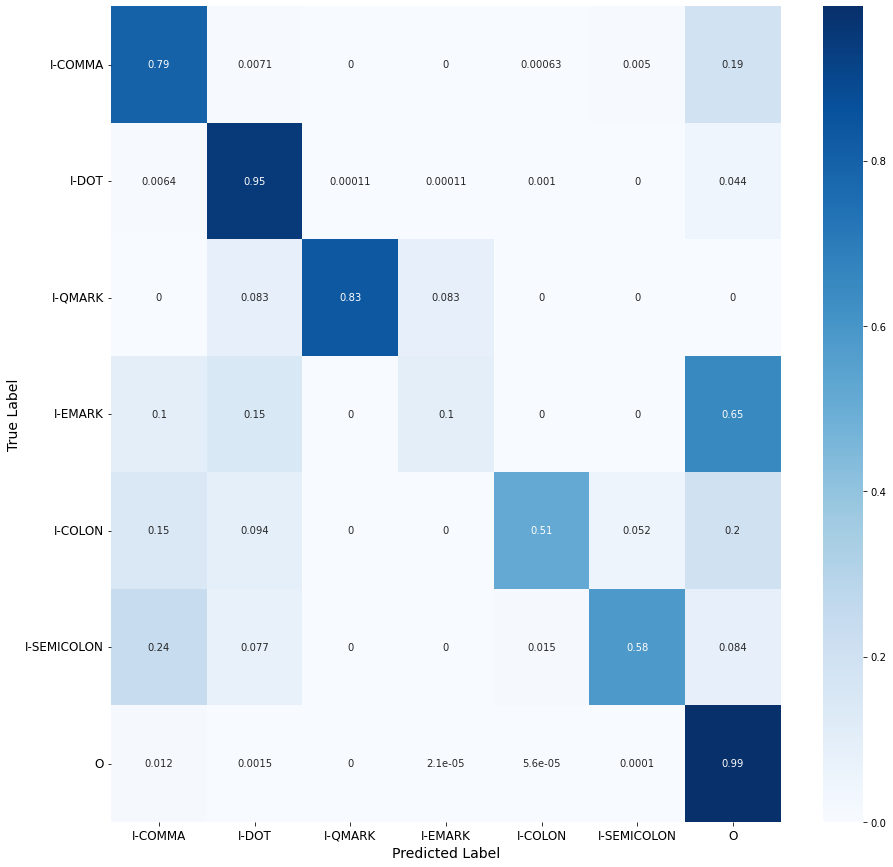

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plot_labels = labels_set
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nor_cm,
            ax=ax, 
            annot=True,
            cmap='Blues',
            xticklabels=plot_labels,
            yticklabels=plot_labels)
plt.yticks(rotation=0,size=12)
plt.xticks(size=12)
ax.set_xlabel('Predicted Label',size=14)
ax.set_ylabel('True Label',size=14)